In [1]:
import numpy as np
from scipy.fft import fft
import matplotlib.pyplot as plt
from PyEMD import EMD,CEEMDAN, EEMD
from sklearn.feature_selection import mutual_info_regression
import warnings
warnings.filterwarnings('ignore')

from ta.trend import ema_indicator

from modules.Utils.utils import loadFromDB, strategyTester
import pandas as pd


In [2]:
def emd(signal):
    emd = EMD(DTYPE=np.float16, spline_kind='cubic')#CEEMDAN() 
    imfs = emd(signal.values)
    
    t = [i for i in range(len(signal))]
    N = imfs.shape[0]
    fig, axs = plt.subplots(N + 1, 1, figsize=(25,11))
    axs[0].plot(t, signal)
    axs[0].set_title('Original Signal')
    for n, imf in enumerate(imfs):
        axs[n+1].plot(t, imf)
        axs[n+1].set_title(f'IMF {n}')
    
    return imfs

In [3]:
SYMBOL= 'BTC'
df = loadFromDB(f'./data/12h/{SYMBOL}-USDT.csv')#.iloc[-2500:]
#df["EMA20"] = ema_indicator(df["Close"], 20)
df.dropna(inplace=True)
print(df.shape)
df.head()

(1957, 6)


,Open,High,Low,Close,Volume,Timestamp
Date,,,,,,
2020-01-01 01:00:00,7195.24,7245.00,7175.46,7197.20,8061.698592,1577836800
2020-01-01 13:00:00,7197.20,7255.00,7175.15,7200.85,8730.689573,1577880000
2020-01-02 01:00:00,7200.77,7212.50,7105.00,7139.79,11959.519197,1577923200
2020-01-02 13:00:00,7139.73,7163.40,6924.74,6965.71,19991.964735,1577966400
2020-01-03 01:00:00,6965.49,7371.92,6871.04,7340.46,40220.086515,1578009600


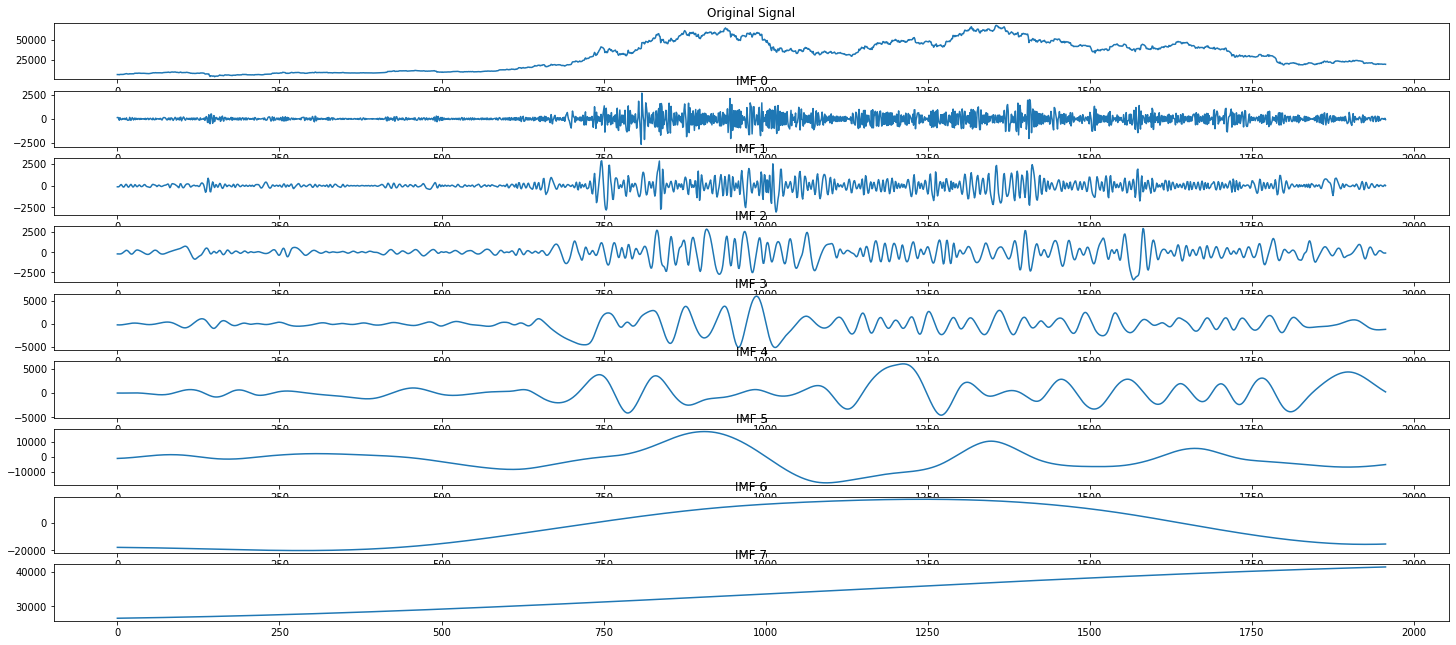

In [4]:
imfs = emd(df["Close"])

In [5]:
def phase_spectrum(imfs):
    imfs_p = []
    fig, axs = plt.subplots(len(imfs), 1, figsize=(25,11))
    for i, imf in enumerate(imfs):
        trans = fft(imf)
        imf_p = np.arctan(trans.imag / trans.real)
        
        imfs_p.append(imf_p)
        
        axs[i].plot(imf_p, 'o')
        axs[i].set_title(f'IMF {i}')
        
    return imfs_p

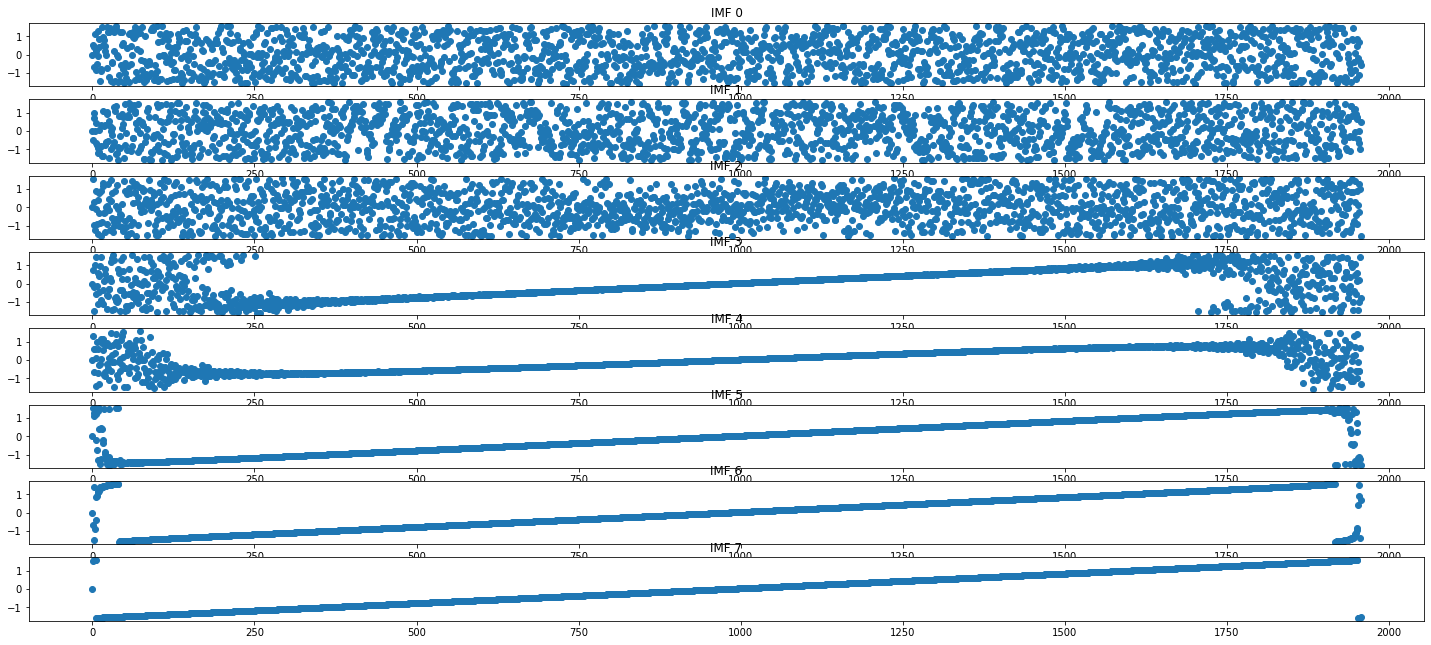

In [6]:
imfs_p = phase_spectrum(imfs)

In [7]:
def phase_mi(phases):
    mis = []
    for i in range(len(phases)-1):
        mis.append(mutual_info_regression(phases[i].reshape(-1, 1), phases[i+1])[0])
        
    return np.array(mis)
mis = phase_mi(imfs_p)

In [8]:
def divide_signal(signal, imfs, mis, cutoff=0.75):
    cut_point = np.where(mis > cutoff)[0][0]
    stochastic_component = np.sum(imfs[:cut_point], axis=0)
    deterministic_component = np.sum(imfs[cut_point:], axis=0)
    
    t = [i for i in range(len(signal))]
    
    fig, axs = plt.subplots(3, 1, figsize=(25,11))
    axs[0].plot(t, signal.values)
    axs[0].set_title('Original Signal')
    
    axs[1].plot(t, stochastic_component)
    axs[1].set_title('Stochastic Component')
    
    axs[2].plot(t, deterministic_component)
    axs[2].set_title('Deterministic Component')
    
    return stochastic_component, deterministic_component

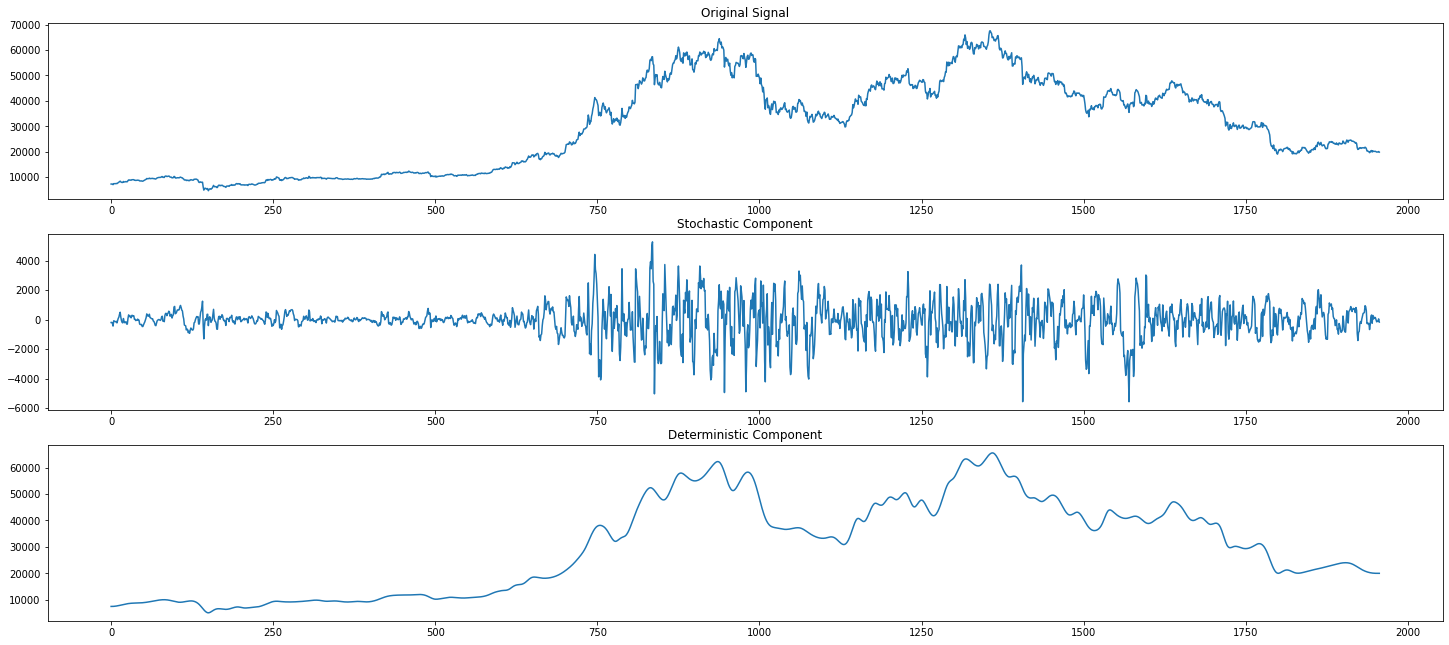

In [9]:
stochastic_component, deterministic_component = divide_signal(df["Close"], imfs, mis,cutoff=0.96)

In [10]:
df['deterministic_component'] = deterministic_component
df['stochastic_component'] = stochastic_component
df['deterministic_component_diff'] = df['deterministic_component'].diff()
df.dropna(inplace=True)

Period : [2020-01-01 13:00:00] -> [2022-09-05 02:00:00]
Starting balance : 1000 $

----- General Informations -----
Final balance : 208272.64 $
Performance vs US Dollar : 20727.26 %
Buy and Hold Performence : 174.68 %
Performance vs Buy and Hold : 11766.17 %
Best trade : +72.98 %, the 2021-02-20 13:00:00
Worst trade : -10.91 %, the 2020-03-03 01:00:00
Worst drawBack : -11.0 %
Total fees :  3380.57 $

----- Trades Informations -----
Total trades on period : 39
Number of positive trades : 32
Number of negative trades :  7
Trades win rate ratio : 82.05 %
Average trades performance : 16.47 %
Average positive trades : 20.89 %
Average negative trades : -3.73 %

----- Plot -----


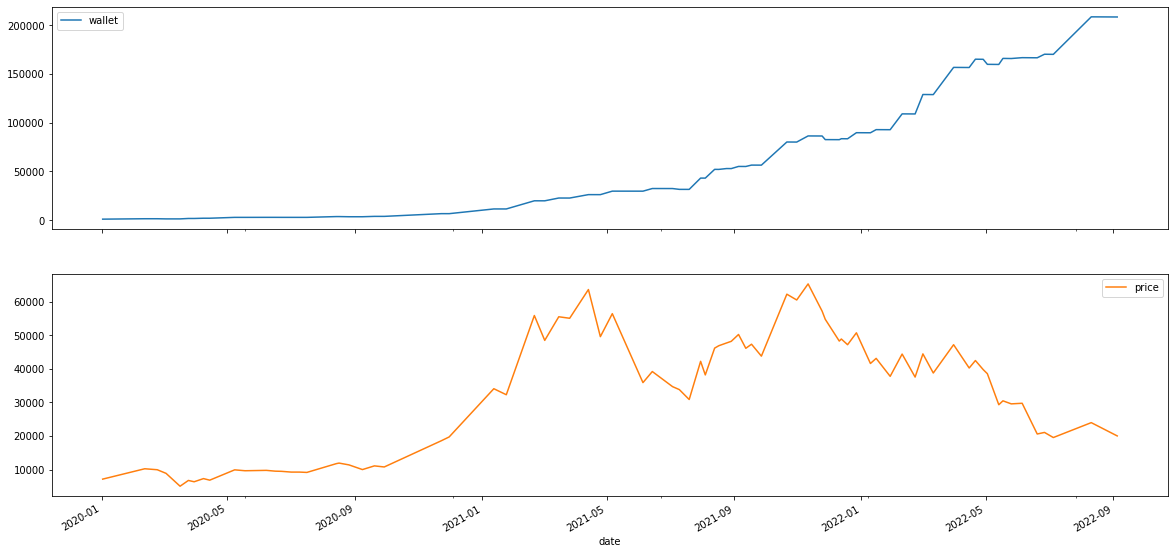

In [11]:
def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.deterministic_component_diff>0 else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.deterministic_component_diff<0 else False

strategyTester(df,buyCondition,sellCondition,equity=1000)

In [12]:
from bokeh.plotting import figure
from bokeh.io import push_notebook,show, output_notebook
from bokeh.models import HoverTool, Band, ColumnDataSource
from bokeh.layouts import row, column
output_notebook()

Loading BokehJS ...

In [13]:

import matplotlib.pyplot as plt

p = figure(title=f"Comparaison", x_axis_label='time', y_axis_label='value ($)',width=1500, height=600,)
# Add the HoverTool to the figure
p.add_tools(HoverTool(
    tooltips=[
    ("Price", "@y{0.00} $"),
], formatters={
        '$x': 'datetime',
        '$y' : 'printf',
    },
    mode='vline'
))
p.line(list(range(len(df))), df.Close.values, legend_label="Close", line_width=2, )
p.line(list(range(len(df))), df.deterministic_component.values, legend_label="Deterministic", line_width=2, color='orange')

p.legend.location = "top_left"

q = figure(title=f"Comparaison", x_axis_label='time', y_axis_label='value',width=1500, height=600,)
# Add the HoverTool to the figure
q.add_tools(HoverTool(
    tooltips=[
    ("Price", "@y{0.00}"),
], formatters={
        '$x': 'datetime',
        '$y' : 'printf',
    },
    mode='vline'
))
q.line(list(range(len(df))), df.deterministic_component_diff.values, legend_label="Deterministic", line_width=2, color='orange')
q.legend.location = "top_left"

show(column(p, q))

# Wrap it up

In [14]:
df_final = pd.DataFrame()
for col in df.columns:
    df_final[col]=np.nan
df_final

,Open,High,Low,Close,Volume,Timestamp,deterministic_component,stochastic_component,deterministic_component_diff


In [15]:
from multiprocessing import Pool, cpu_count

kucoin_range = 100

def processBatch(i):
    df_i = df.iloc[i:i+kucoin_range]
    imfs = emd(df_i["Close"])
    imfs_p = phase_spectrum(imfs)
    mis = phase_mi(imfs_p)
    stochastic_component, deterministic_component = divide_signal(df_i["Close"], imfs, mis,cutoff=0.96)
    df_i['deterministic_component'] = deterministic_component
    df_i['stochastic_component'] = stochastic_component
    df_i['deterministic_component_diff'] = df_i['deterministic_component'].diff()
    return df_i.iloc[-1]
    #df_final = df_final.append(df_i.iloc[-1],ignore_index=True)
    #print(f'{len(df_final)} records')
    
with Pool(3) as pool:
    # call the same function with different data in parallel
    results = pool.map(processBatch, range(len(df)-kucoin_range))
    for result in results:
        # report the value to show progress
        df_final = df_final.append(result,ignore_index=True)
        print(f'{len(df_final)} records')

In [ ]:
from datetime  import datetime
df_final['date'] = df_final['Timestamp'].astype(int).apply(lambda x: datetime.fromtimestamp(x))
df_final.sort_values('date',inplace=True)
df_final.set_index('date',inplace=True)

strategyTester(df_final,buyCondition,sellCondition,equity=1000)